## Environment Setting and Data Loading

In [15]:
import pandas as pd
import numpy as np

In [2]:
import spacy

2023-05-24 22:43:28.391733: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 22:43:29.522751: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load li

In [16]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
num_processors

16

In [17]:
from pandarallel import pandarallel

# Initialize pandarallel
pandarallel.initialize(nb_workers = multiprocessing.cpu_count()-2, use_memory_fs=False, progress_bar=True)

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [10]:
"""
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
"""

"\npd.set_option('display.max_rows', 100)\npd.set_option('display.max_columns', None)\npd.set_option('display.max_colwidth', None)\n"

In [11]:
df_filtered = pd.read_parquet('filtered_data_sentiment.parquet')

In [12]:
df_filtered.head()

,date,domain,clean_title,clean_text,clean_token,sentiment_score_vader,sentiment_vader,sentiment_svm,sentiment_score_vader_customized,sentiment_vader_customized
0,2021-03-18,en.people.cn,Artificial intelligence improves parking effic...,Thanks to the application of an artificial int...,thanks application artificial intelligence ai ...,0.9970,Positive,0,0.9961,Positive
1,2020-02-27,newsparliament.com,Children With Autism Saw Their Learning and So...,Coronavirus Could Explode in the U.S. Overnigh...,coronavirus could explode overnight like italy...,0.9988,Positive,0,0.9987,Positive
2,2021-03-26,www.dataweek.co.za,"Forget ML, AI and Industry 4.0",*mar21-abi Many decision-makers only realise t...,many realise problem hand regret following tag...,0.9965,Positive,0,0.9974,Positive
3,2021-03-10,www.homeoffice.consumerelectronicsnet.com,Strategy Analytics: 71% of Smartphones Sold Gl...,BOSTON–(BUSINESS WIRE)–Strategy Analytics in a...,business wire analytics newly published report...,0.9991,Positive,1,0.9990,Positive
4,2020-10-20,www.itbusinessnet.com,Olympus to Support Endoscopic AI Diagnosis Edu...,"TOKYO, Oct 20, 2020 – (ACN Newswire) – Olympus...",tokyo oct acn newswire olympus corporation too...,0.9936,Positive,0,0.9956,Positive


In [13]:
df_filtered.shape

(165530, 10)

In [14]:
df_filtered.clean_text[0]

"Thanks to the application of an artificial intelligence (AI)-empowered roadside electronic toll collection (ETC) system, China’s capital city Beijing has seen significant improvement in the efficiency of parking fee collection, turnover of roadside parking spots, order in roadside parking, as well as traffic congestion. As the city further deepens its roadside parking reform, the ETC system has almost covered all the roadside parking spaces in the city, with the proportion of vehicles parked on roads using the system exceeding 90 percent. With the AI-empowered system, drivers can park their vehicles at the parking spots on the roadside, and then pay the parking charge via their mobile phones after they drive away. “This road used to be full of cars, and even the normal lanes were occupied. You could hardly move a bit during the morning and evening commute time,” recalled a citizen surnamed Wang, who lives in Chaoyang district of Beijing. “Since the summer of 2019, roadside ETC devices

## NER with Spacy (News Level)

#### UDF

In [15]:
nlp = spacy.load("en_core_web_sm")

In [16]:
def spacy_NER_word(text, nlp):
    doc = nlp(text)
    org_entities = [ent.text for ent in doc.ents if ent.label_ == 'ORG']
    person_entities = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']
    gpe_entities = [ent.text for ent in doc.ents if ent.label_ == 'GPE']
    return [org_entities, person_entities, gpe_entities]

In [17]:
from functools import partial
spacy_NER_word_nlp = partial(spacy_NER_word, nlp=nlp)

In [18]:
from collections import defaultdict

def ner_sentiment_vader(df, entity_col, mask_threshold, n):
    # Initialize a dict to hold total sentiment scores and counts for each entity
    entity_sentiment_dict = defaultdict(lambda: {'total_sentiment': 0, 'count': 0})

    # Iterate over the dataframe
    for i, row in df.iterrows():
        for entity in row[entity_col]:
            entity_sentiment_dict[entity]['total_sentiment'] += row['sentiment_score_vader']
            entity_sentiment_dict[entity]['count'] += 1 

    # Calculate the average sentiment score for each entity
    for entity in entity_sentiment_dict:
        entity_sentiment_dict[entity]['average_sentiment'] = entity_sentiment_dict[entity]['total_sentiment'] / entity_sentiment_dict[entity]['count']

    # Convert the dict to a DataFrame
    df_entity_sentiment = pd.DataFrame.from_records(list(entity_sentiment_dict.items()), columns=['Entity', 'Stats'])

    # Extract the total sentiment, count and average sentiment to separate columns
    df_entity_sentiment['Total_Sentiment'] = df_entity_sentiment['Stats'].apply(lambda x: x['total_sentiment'])
    df_entity_sentiment['Count'] = df_entity_sentiment['Stats'].apply(lambda x: x['count'])
    df_entity_sentiment['Average_Sentiment'] = df_entity_sentiment['Stats'].apply(lambda x: x['average_sentiment'])

    # Drop the Stats column as we have separated its elements into different columns
    df_entity_sentiment.drop('Stats', axis=1, inplace=True)

    # Create a mask for entities that appear more than mask_threshold times
    mask = df_entity_sentiment['Count'] > mask_threshold

    # Apply the mask to the DataFrame
    df_filtered_entity_sentiment = df_entity_sentiment[mask] 
    
    # Sort by the average sentiment score and take the top n
    df_top_entity_count = df_filtered_entity_sentiment.sort_values(by='Count', ascending=False).head(n)
    df_bottom_entity_count = df_filtered_entity_sentiment.sort_values(by='Count', ascending=True).head(n)

    df_top_entity_avg = df_filtered_entity_sentiment.sort_values(by='Average_Sentiment', ascending=False).head(n)
    df_bottom_entity_avg = df_filtered_entity_sentiment.sort_values(by='Average_Sentiment', ascending=True).head(n)   
    
    return [df_top_entity_count, df_bottom_entity_count, df_top_entity_avg, df_bottom_entity_avg]




In [19]:
def ner_sentiment_svm(df, entity_col, mask_threshold, n):
    # Initialize a dict to hold total sentiment counts for each entity
    entity_sentiment_dict = defaultdict(lambda: {'positive_count': 0, 'negative_count': 0})

    # Iterate over the dataframe
    for i, row in df.iterrows():
        for entity in row[entity_col]:
            if row['sentiment_svm'] == 1:  # Positive sentiment
                entity_sentiment_dict[entity]['positive_count'] += 1
            else:  # Negative sentiment
                entity_sentiment_dict[entity]['negative_count'] += 1

    # Calculate the positive and negative sentiment ratio for each entity
    for entity in entity_sentiment_dict:
        total_count = entity_sentiment_dict[entity]['positive_count'] + entity_sentiment_dict[entity]['negative_count']
        entity_sentiment_dict[entity]['positive_ratio'] = entity_sentiment_dict[entity]['positive_count'] / total_count
        entity_sentiment_dict[entity]['negative_ratio'] = entity_sentiment_dict[entity]['negative_count'] / total_count

    # Convert the dict to a DataFrame
    df_entity_sentiment = pd.DataFrame.from_records(list(entity_sentiment_dict.items()), columns=['Entity', 'Stats'])

    # Extract the counts and ratios to separate columns
    df_entity_sentiment['Positive_Count'] = df_entity_sentiment['Stats'].apply(lambda x: x['positive_count'])
    df_entity_sentiment['Negative_Count'] = df_entity_sentiment['Stats'].apply(lambda x: x['negative_count'])
    df_entity_sentiment['Positive_Ratio'] = df_entity_sentiment['Stats'].apply(lambda x: x['positive_ratio'])
    df_entity_sentiment['Negative_Ratio'] = df_entity_sentiment['Stats'].apply(lambda x: x['negative_ratio'])

    # Drop the Stats column as we have separated its elements into different columns
    df_entity_sentiment.drop('Stats', axis=1, inplace=True)

    # Create a mask for entities that appear more than mask_threshold times
    mask = (df_entity_sentiment['Positive_Count'] + df_entity_sentiment['Negative_Count']) > mask_threshold

    # Apply the mask to the DataFrame
    df_filtered_entity_sentiment = df_entity_sentiment[mask] 

    # Sort by the count and ratio
    df_top_positive_count = df_filtered_entity_sentiment.sort_values(by='Positive_Count', ascending=False).head(n)
    df_top_negative_count = df_filtered_entity_sentiment.sort_values(by='Negative_Count', ascending=False).head(n)

    df_top_positive_ratio = df_filtered_entity_sentiment.sort_values(by='Positive_Ratio', ascending=False).head(n)
    df_top_negative_ratio = df_filtered_entity_sentiment.sort_values(by='Negative_Ratio', ascending=False).head(n)   

    return [df_top_positive_count, df_top_negative_count, df_top_positive_ratio, df_top_negative_ratio]


#### Sample

In [20]:
df_sample = df_filtered.sample(n=10000)

In [21]:
# Apply the function and split the result into three new columns
df_sample['NER_word'] = df_sample['clean_text'].parallel_apply(spacy_NER_word_nlp)

In [22]:
# Create the new columns from the lists
df_sample[['ORG_NER', 'PERSON_NER', 'GPE_NER']] = pd.DataFrame(df_sample['NER_word'].tolist(), index= df_sample.index)

In [23]:
df_sample.head()

,date,domain,clean_title,clean_text,clean_token,sentiment_score_vader,sentiment_vader,sentiment_svm,sentiment_score_vader_customized,sentiment_vader_customized,NER_word,ORG_NER,PERSON_NER,GPE_NER
97484,2023-03-02,www.kswo.com,Norton Consumer Cyber Safety Pulse Report: Sca...,"Connect, Shop, BuyClick to email a news tipPe...",connect shop buyclick email news tippet weekne...,0.6124,Positive,0,0.6124,Positive,"[[Shop, BuyClick], [], [malwareTEMPE, Ariz., P...","[Shop, BuyClick]",[],"[malwareTEMPE, Ariz., PRAGUE]"
6899,2021-01-19,technoweekly.com,AI Primarily based Chatbots Marketplace Expand...,"Amazon (US),Dialogflow (Google) (US),Bold360 ...",amazon u dialogflow google u ai u chatfuel u b...,0.9987,Positive,1,0.9984,Positive,"[[Amazon, US),Bold360 AI, Germany),IBM Company...","[Amazon, US),Bold360 AI, Germany),IBM Company ...","[US),Botsify, Meter Marketplace, Thales Workfo...","[Yiling, Makita, Saudi Arabia, UAE, Egypt, Nig..."
80498,2021-12-13,www.popsci.com,Caltech's aquatic robot uses AI to navigate th...,This tiny AI-powered robot is learning to expl...,tiny robot learning explore ocean new caltech ...,0.9976,Positive,1,0.9977,Positive,"[[Caltech, AI, the National Oceanic and Atmosp...","[Caltech, AI, the National Oceanic and Atmosph...","[John O. Dabiri, Peter Gunnarson, Gunnarson, G...","[Caltech, Koumoutsakos]"
17802,2022-12-16,newslanes.com,How Can AI Reach Its Full Potential?,"AI vision, such as image processing with artif...",ai vision image processing artificial intellig...,0.9989,Positive,1,0.9992,Positive,"[[AI, AI, AI, ML, AI, AI, AI, IDS Imaging Deve...","[AI, AI, AI, ML, AI, AI, AI, IDS Imaging Devel...",[],[]
12631,2020-05-11,countercurrents.org,Rabindranath Tagore: A Universal Bard,Rabindranath Tagore (1861 to 1941) was born on...,rabindranath tagore born may brilliant poet wr...,0.9996,Positive,1,0.9996,Positive,"[[First Light, Gangopadhyay, Gaaner, Purabi, t...","[First Light, Gangopadhyay, Gaaner, Purabi, th...","[Rabindranath Tagore, Sahitya, Aruna Chakravar...","[Tagore, Tagore, Jorasanko, India, Tagore, Koc..."


In [24]:
df_sample.ORG_NER.head()

97484                                     [Shop, BuyClick]
6899     [Amazon, US),Bold360 AI, Germany),IBM Company ...
80498    [Caltech, AI, the National Oceanic and Atmosph...
17802    [AI, AI, AI, ML, AI, AI, AI, IDS Imaging Devel...
12631    [First Light, Gangopadhyay, Gaaner, Purabi, th...
Name: ORG_NER, dtype: object

In [25]:
ner_sentiment_vader(df_sample, 'ORG_NER', 50, 20)[2]

,Entity,Total_Sentiment,Count,Average_Sentiment
33593,Quantum AI,61.9867,62,0.999785
30974,Supply Chain and Logistics,51.9826,52,0.999665
5059,Cyber Security,106.9268,107,0.999316
6190,Drug Discovery,62.9518,63,0.999235
2212,Prisma,77.9295,78,0.999096
449,the Global Artificial Intelligence,80.9214,81,0.999030
436,Global Artificial Intelligence,227.7633,228,0.998962
451,the Artificial Intelligence (AI,485.4898,486,0.998950
1649,the Artificial Intelligence,263.7142,264,0.998917
30339,Global X Robotics & Artificial Intelligence ETF,74.9168,75,0.998891


#### Full Dataset

In [26]:
%%time
df_filtered['NER_word'] = df_filtered['clean_text'].parallel_apply(spacy_NER_word_nlp)

CPU times: total: 1min
Wall time: 37min 4s


In [27]:
df_filtered[['ORG_NER', 'PERSON_NER', 'GPE_NER']] = pd.DataFrame(df_filtered['NER_word'].tolist(), index= df_filtered.index)

In [28]:
%%time
ner_sentiment_vader(df_filtered, 'ORG_NER', 100, 20)[0]

CPU times: total: 7.89 s
Wall time: 14.8 s


,Entity,Total_Sentiment,Count,Average_Sentiment
1,AI,194865.0000,229241,0.850044
191,Microsoft,48419.8386,58651,0.825559
50,Google,28141.9650,36970,0.761211
422,OpenAI,16326.0438,22359,0.730178
295,ML,18516.6625,20374,0.908838
259,Amazon,16323.9927,18643,0.875610
179,IBM,17252.9131,18110,0.952673
492,Artificial Intelligence,11895.0045,12529,0.949398
1684,NYSE,11495.5177,12324,0.932775
254,Apple,9239.9606,10780,0.857139


In [29]:
ner_sentiment_vader(df_filtered, 'ORG_NER', 100, 20)[2]

,Entity,Total_Sentiment,Count,Average_Sentiment
14870,this State of the Union,158.0000,158,1.000000
5727,Naim,311.9498,312,0.999839
5724,Pollogen,155.9749,156,0.999839
5725,Geneo Personal,155.9749,156,0.999839
5723,Apple's XS,155.9749,156,0.999839
5728,Mu-So Qb,155.9749,156,0.999839
5722,Home Hub,154.9750,155,0.999839
5721,Google Home Hub review Google,154.9750,155,0.999839
17762,Tech Gaming Headphones Laptops Mobile Accessories,125.9774,126,0.999821
17761,the Goldilocks of Smartphones Mobile World Con...,125.9774,126,0.999821


In [30]:
df_filtered.to_parquet('filtered_data_sentiment_NER.parquet', engine='pyarrow')

#### Interested Industry

In [ ]:
df_automotive = pd.read_csv('df_automotive.csv')
df_writing = pd.read_csv('df_writing.csv')
df_entertainment = pd.read_csv('df_entertainment.csv')
df_healthcare = pd.read_csv('df_healthcare.csv')

In [ ]:
%%time
df_automotive['ORG_NER'] = df_automotive['clean_text'].parallel_apply(spacy_NER_with_nlp)
df_writing['ORG_NER'] = df_writing['clean_text'].parallel_apply(spacy_NER_with_nlp)
df_entertainment['ORG_NER'] = df_entertainment['clean_text'].parallel_apply(spacy_NER_with_nlp)
df_healthcare['ORG_NER'] = df_healthcare['clean_text'].parallel_apply(spacy_NER_with_nlp)

CPU times: user 49.6 s, sys: 12.2 s, total: 1min 1s
Wall time: 19min 42s


In [ ]:
calculate_org_sentiment(df_automotive, 50, 20)

(                                                Entity  Total_Sentiment  \
 543  NorTech Offers European Organizations Free Sim...            182.0   
 389                                                RCH            183.0   
 396           Digital Cable Systems SA AKTA Telecom SA            183.0   
 395                                         XPAND Code            183.0   
 394                               XPAND Code Generator            183.0   
 393                                              XPAND            183.0   
 392                         the Best Guest Room Tablet            183.0   
 391                                           SuitePad            183.0   
 390                                Vintage POS Systems            183.0   
 388                             DIGI Communications NV           2379.0   
 339                              Attractions Eveliqure            170.0   
 387                                            Invitel            366.0   
 386        

In [ ]:
calculate_org_sentiment(df_writing, 50, 20)

(                                                  Entity  Total_Sentiment  \
 20633                                               DIGI          95.0000   
 1003                                   KATHERINE JOHNSON         155.0000   
 1001                                    Abraham Lincolns         155.0000   
 1336                the Comedians In Cars Getting Coffee          59.0000   
 1002                              the State of the Union         155.0000   
 20632                             DIGI COMMUNICATIONS NV          87.0000   
 1006                                               BIDEN          96.0000   
 1005                                   the Union Address         155.0000   
 1004                                                ELON          97.9991   
 869                                   Paris Fashion Week         117.9887   
 970                                                  PDA          54.9929   
 2032                                              Nicola       

In [ ]:
calculate_org_sentiment(df_entertainment, 50, 20)

(                                                Entity  Total_Sentiment  \
 181                                      the Cloud ASI             98.0   
 234                     RW Chelsea Holdings Ltd Starts             98.0   
 232        Digi Communications NV Group Mono Solutions             98.0   
 231       Availability of Preliminary Financial Report             98.0   
 230                                    Groups Romanian             98.0   
 229  Irish Stock Exchanges Main Securities Market D...             98.0   
 228                                   Mr Sambor Ryszka             98.0   
 227                        European Email Verification             98.0   
 226                 Digi Communications NV Convocation             98.0   
 225                             Additive Manufacturing             98.0   
 224                         European Regulatory Status             98.0   
 223                         Society UKTS Clarification             98.0   
 222        

In [ ]:
calculate_org_sentiment(df_healthcare, 100, 20)

(                                                Entity  Total_Sentiment  \
 558                                             RPharm            183.0   
 457        Digi Communications NV Group Mono Solutions            183.0   
 455                                    Groups Romanian            183.0   
 454  Irish Stock Exchanges Main Securities Market D...            183.0   
 453                                   Mr Sambor Ryszka            183.0   
 452                        European Email Verification            183.0   
 451                 Digi Communications NV Convocation            183.0   
 449                         European Regulatory Status            183.0   
 448                         Society UKTS Clarification            183.0   
 447                          Associazione Veneta Lotta            183.0   
 446      Focus on Concrete Actions Digi Communications            183.0   
 445                                    World Community            183.0   
 444  Biodiv

In [ ]:
df_filtered.to_parquet('filtered_data_sentiment_NER.parquet', engine='pyarrow')

## NER and Sentiment Analysis in Sentence Level

In [4]:
import pandas as pd

In [6]:
df_filtered = pd.read_pickle('filtered_data_sentiment_NER.pkl')
df_filtered.shape

(165530, 16)

In [7]:
df_filtered.head()

,date,domain,clean_title,clean_text,clean_token,sentiment_score_vader,sentiment_vader,sentiment_svm,sentiment_score_vader_customized,sentiment_vader_customized,NER_word,ORG_NER,PERSON_NER,GPE_NER,sentiment_ner,sentiment_bert
0,2021-03-18,en.people.cn,Artificial intelligence improves parking effic...,Thanks to the application of an artificial int...,thanks application artificial intelligence ai ...,0.9970,Positive,0,0.9961,Positive,"[[ETC, ETC, AI, Wang, ETC, Wang, ETC, Ministry...","[ETC, ETC, AI, Wang, ETC, Wang, ETC, Ministry ...","[Xiang Yanping, Xiang]","[China, Beijing, Chaoyang, Beijing, Beijing, B...",E...,Positive
1,2020-02-27,newsparliament.com,Children With Autism Saw Their Learning and So...,Coronavirus Could Explode in the U.S. Overnigh...,coronavirus could explode overnight like italy...,0.9988,Positive,0,0.9987,Positive,"[[Kiwi, the University of Southern California,...","[Kiwi, the University of Southern California, ...","[Levi Strauss, Kiwi, Kiwi, Kiwi, Shomik Jain, ...","[Explode, U.S., Explode, U.S., U.S., South Car...",...,Negative
2,2021-03-26,www.dataweek.co.za,"Forget ML, AI and Industry 4.0",*mar21-abi Many decision-makers only realise t...,many realise problem hand regret following tag...,0.9965,Positive,0,0.9974,Positive,"[[LinkedIn, BoardMaster, GE Renewable to Colli...","[LinkedIn, BoardMaster, GE Renewable to Collin...","[Lego, SFMTA, Heraeus]","[US, Brazil, Mexico, US, Alstom, China]",...,Negative
3,2021-03-10,www.homeoffice.consumerelectronicsnet.com,Strategy Analytics: 71% of Smartphones Sold Gl...,BOSTON–(BUSINESS WIRE)–Strategy Analytics in a...,business wire analytics newly published report...,0.9991,Positive,1,0.9990,Positive,[[Global Artificial Intelligence Technologies ...,[Global Artificial Intelligence Technologies F...,"[Associate Director, Ville-Petteri Ukonaho, Pr...",[Illinois],...,Positive
4,2020-10-20,www.itbusinessnet.com,Olympus to Support Endoscopic AI Diagnosis Edu...,"TOKYO, Oct 20, 2020 – (ACN Newswire) – Olympus...",tokyo oct acn newswire olympus corporation too...,0.9936,Positive,0,0.9956,Positive,"[[Olympus Corporation, the Ministry of Interna...","[Olympus Corporation, the Ministry of Internal...","[Magnifying Endoscopes, Satoshi Hemmi, EndoBRA...","[TOKYO, India, India, Hyderabad, India, India,...",...,Positive


In [8]:
import pandas as pd
import nltk
import spacy  

2023-05-25 00:14:37.890961: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 00:14:38.869254: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load li

In [58]:
# !pip install vaderSentiment

In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [10]:
customized_analyzer = SentimentIntensityAnalyzer()
customized_analyzer.lexicon.update({
    word: 1.0 for word in ['breakthrough', 'innovation', 'scalability', 'streamlining', 'exploration', 'flexible', 'creation', 'sustainable', 'unleash', 'dynamic', 'empower', 'proactive', 'responsive', 'collaborative', 'integrated', 'personalization', 'inclusive', 'advancement', 'profitability', 'outperform', 'exceed', 'tailored', 'seamless', 'leverage', 'enhancement', 'unprecedented', 'revolutionary', 'groundbreaking', 'mining','opportunity', 'growth', 'automation', 'efficiency', 'productivity', 'competitiveness', 'prospects','development', 'progress', 'transformation', 'intelligence', 'digitization', 'smart', 'wisdom', 'optimization', 'data-driven',  'accuracy', 'high-quality', 'high-efficiency', 'cost-saving', 'safety', 'reliability',  'leading', 'leader', 'competitor', 'advantage', 'accelerate', 'excel', 'reinvent', 'simplify', 'maximize', 'enrich', 'facilitate', 'inspire', 'ignite', 'cultivate', 'reliable', 'diversify', 'monetize', 'empowering', 'interoperability', 'ingenuity', 'visionary', 'meticulous', 'proliferation', 'synergize', 'enhance', 'adaptive', 'revitalize', 'rejuvenate', 'spearhead']
})

customized_analyzer.lexicon.update({
    word: -1.0 for word in ['disruptive', 'detrimental', 'compromise', 'vulnerable', 'intrusive', 'exploitation', 'overdependence', 'oversimplification', 'misinterpretation', 'bias', 'unethical', 'exclusion', 'distrust', 'alienation', 'fraudulent', 'counterfeit', 'substandard', 'obsolete', 'impersonal', 'inefficient', 'loss', 'high risk', 'heavy burden', 'high challenge',  'opposition','stagnation', 'inflexibility','unemployment', 'uncertainty', 'contraction', 'reduction', 'downsizing', 'bottleneck', 'challenge', 'obstacle', 'risk', 'insecurity', 'instability', 'unreliability',  'restriction', 'limitation', 'regression', 'backwardness', 'failure', 'defect', 'problem', 'difficulty', 'negative', 'pessimistic', 'worry', 'fear', 'inadequacy', 'pressure', 'struggle', 'plight', 'crisis', 'frustration', 'disappointment', 'injury', 'hopelessness', 'pessimism', 'downward trend', 'stubbornness', 'conservatism', 'resistance', 'constraint',  'outdated', 'slow', 'low-efficiency', 'low-quality', 'high-cost']
})

In [11]:
nlp = spacy.load("en_core_web_sm")

In [12]:
def sentiment_NER(text):


    entities = []
    labels = []
    sentiment = []
    sentiment_score = []

    for sent in nltk.sent_tokenize(text):
        doc = nlp(sent)
        for ent in doc.ents:
            if ent.label_ in ['ORG', 'GPE', 'PERSON', 'LOC', 'PRODUCT']:
                entities.append(ent.text)
                labels.append(ent.label_)
                score = customized_analyzer.polarity_scores(sent)
                sentiment.append('Positive' if score['compound'] > 0 else 'Neutral' if score['compound'] == 0 else 'Negative')
                sentiment_score.append(score['compound'])

    return pd.DataFrame({
        'Entity': entities,
        'Label': labels,
        'Sentiment': sentiment,
        'Sentiment_Score': sentiment_score
    })



In [13]:
import ipywidgets
print(ipywidgets.__version__)

8.0.6


In [18]:
%%time
df_filtered['sentiment_ner_with_product'] = df_filtered.clean_text.parallel_apply(sentiment_NER)

CPU times: user 2min 8s, sys: 18.2 s, total: 2min 26s
Wall time: 2h 29min 3s


In [20]:
df_filtered.sentiment_ner_with_product[0]

,Entity,Label,Sentiment,Sentiment_Score
0,ETC,ORG,Positive,0.8957
1,China,GPE,Positive,0.8957
2,Beijing,GPE,Positive,0.8957
3,ETC,ORG,Neutral,0.0000
4,AI,ORG,Negative,-0.1027
5,Wang,PERSON,Neutral,0.0000
6,Chaoyang,GPE,Neutral,0.0000
7,Beijing,GPE,Neutral,0.0000
8,ETC,ORG,Neutral,0.0000
9,Wang,ORG,Positive,0.3818


In [21]:
df_filtered.head(1)

,date,domain,clean_title,clean_text,clean_token,sentiment_score_vader,sentiment_vader,sentiment_svm,sentiment_score_vader_customized,sentiment_vader_customized,NER_word,ORG_NER,PERSON_NER,GPE_NER,sentiment_ner,sentiment_bert,sentiment_ner_with_product
0,2021-03-18,en.people.cn,Artificial intelligence improves parking effic...,Thanks to the application of an artificial int...,thanks application artificial intelligence ai ...,0.997,Positive,0,0.9961,Positive,"[[ETC, ETC, AI, Wang, ETC, Wang, ETC, Ministry...","[ETC, ETC, AI, Wang, ETC, Wang, ETC, Ministry ...","[Xiang Yanping, Xiang]","[China, Beijing, Chaoyang, Beijing, Beijing, B...",E...,Positive,E...


In [32]:
df_filtered.to_pickle('filtered_data_sentiment_NER.pkl')

#### Extract sentiment_ner_with_product

In [4]:
import pandas as pd
df_sentiment_with_product = pd.read_pickle('filtered_data_sentiment_NER.pkl')
df_sentiment_with_product.head()

,date,domain,clean_title,clean_text,clean_token,sentiment_score_vader,sentiment_vader,sentiment_svm,sentiment_score_vader_customized,sentiment_vader_customized,NER_word,ORG_NER,PERSON_NER,GPE_NER,sentiment_ner,sentiment_bert,sentiment_ner_with_product
0,2021-03-18,en.people.cn,Artificial intelligence improves parking effic...,Thanks to the application of an artificial int...,thanks application artificial intelligence ai ...,0.9970,Positive,0,0.9961,Positive,"[[ETC, ETC, AI, Wang, ETC, Wang, ETC, Ministry...","[ETC, ETC, AI, Wang, ETC, Wang, ETC, Ministry ...","[Xiang Yanping, Xiang]","[China, Beijing, Chaoyang, Beijing, Beijing, B...",E...,Positive,E...
1,2020-02-27,newsparliament.com,Children With Autism Saw Their Learning and So...,Coronavirus Could Explode in the U.S. Overnigh...,coronavirus could explode overnight like italy...,0.9988,Positive,0,0.9987,Positive,"[[Kiwi, the University of Southern California,...","[Kiwi, the University of Southern California, ...","[Levi Strauss, Kiwi, Kiwi, Kiwi, Shomik Jain, ...","[Explode, U.S., Explode, U.S., U.S., South Car...",...,Negative,Entity Label Sentiment Sent...
2,2021-03-26,www.dataweek.co.za,"Forget ML, AI and Industry 4.0",*mar21-abi Many decision-makers only realise t...,many realise problem hand regret following tag...,0.9965,Positive,0,0.9974,Positive,"[[LinkedIn, BoardMaster, GE Renewable to Colli...","[LinkedIn, BoardMaster, GE Renewable to Collin...","[Lego, SFMTA, Heraeus]","[US, Brazil, Mexico, US, Alstom, China]",...,Negative,...
3,2021-03-10,www.homeoffice.consumerelectronicsnet.com,Strategy Analytics: 71% of Smartphones Sold Gl...,BOSTON–(BUSINESS WIRE)–Strategy Analytics in a...,business wire analytics newly published report...,0.9991,Positive,1,0.9990,Positive,[[Global Artificial Intelligence Technologies ...,[Global Artificial Intelligence Technologies F...,"[Associate Director, Ville-Petteri Ukonaho, Pr...",[Illinois],...,Positive,...
4,2020-10-20,www.itbusinessnet.com,Olympus to Support Endoscopic AI Diagnosis Edu...,"TOKYO, Oct 20, 2020 – (ACN Newswire) – Olympus...",tokyo oct acn newswire olympus corporation too...,0.9936,Positive,0,0.9956,Positive,"[[Olympus Corporation, the Ministry of Interna...","[Olympus Corporation, the Ministry of Internal...","[Magnifying Endoscopes, Satoshi Hemmi, EndoBRA...","[TOKYO, India, India, Hyderabad, India, India,...",...,Positive,...


In [15]:
df_sentiment_with_product.sentiment_ner_with_product[7].Label.value_counts()

ORG        42
GPE        10
PERSON      5
PRODUCT     4
Name: Label, dtype: int64

In [18]:
sentiment_ner_with_product = pd.DataFrame(df_sentiment_with_product['sentiment_ner_with_product'])
sentiment_ner_with_product.head(1)

,sentiment_ner_with_product
0,E...


In [22]:
sentiment_ner_with_product_1 = sentiment_ner_with_product.iloc[:80000]
sentiment_ner_with_product_1.shape

(80000, 1)

In [23]:
sentiment_ner_with_product_2 = sentiment_ner_with_product.iloc[80000:]
sentiment_ner_with_product_2.shape

(85530, 1)

In [24]:
sentiment_ner_with_product_1.to_pickle('sentiment_ner_with_product_1.pkl')
sentiment_ner_with_product_2.to_pickle('sentiment_ner_with_product_2.pkl')

## Analysis


In [5]:
df_filtered = pd.read_pickle('filtered_data_sentiment_NER.pkl')
df_filtered.shape

(165530, 16)

In [2]:
def analyze_entity(df, label, threshold, sortby, ascending, n):
    df['Positive'] = df['Sentiment'].apply(lambda x: x == 'Positive')
    df['Negative'] = df['Sentiment'].apply(lambda x: x == 'Negative')

    df_grouped = df.groupby(['Entity', 'Label']).agg(
        total_sentiment=('Sentiment_Score', 'sum'),
        count=('Sentiment_Score', 'count'),
        average_sentiment=('Sentiment_Score', 'mean'),
        positive_count=('Positive', 'sum'),
        negative_count=('Negative', 'sum'),
    ).reset_index()

    df_grouped = df_grouped[df_grouped['Label'] == label]
    df_grouped = df_grouped[df_grouped['count'] > threshold]
    df_grouped = df_grouped.sort_values(by=sortby, ascending=ascending)

    return df_grouped.head(n)


In [29]:
ner_sentiment_all = pd.concat(df_filtered['sentiment_ner_with_product'].tolist())
ner_sentiment_all.head()

,Entity,Label,Sentiment,Sentiment_Score
0,ETC,ORG,Positive,0.8957
1,China,GPE,Positive,0.8957
2,Beijing,GPE,Positive,0.8957
3,ETC,ORG,Neutral,0.0000
4,AI,ORG,Negative,-0.1027


In [30]:
ner_sentiment_all[ner_sentiment_all.Label == 'PRODUCT'].head()

,Entity,Label,Sentiment,Sentiment_Score
20,Pivot Point Resistance,PRODUCT,Negative,-0.4215
5,CEVA,PRODUCT,Positive,0.7964
11,CEVA,PRODUCT,Positive,0.4588
35,CEVA,PRODUCT,Positive,0.7960
47,Radar,PRODUCT,Positive,0.7003


In [25]:
analyze_entity(ner_sentiment_all, 'ORG', 500, 'count', False, 10)

,Entity,Label,total_sentiment,count,average_sentiment,positive_count,negative_count
11754,AI,ORG,77448.6245,232549,0.333042,159773,33641
514817,Microsoft,ORG,17749.7820,58707,0.302345,38485,7988
330435,Google,ORG,8231.8232,35680,0.230713,21260,7213
479060,ML,ORG,8037.0736,20343,0.395078,15130,2294
573975,OpenAI,ORG,5473.4163,20209,0.270841,12740,2967
47543,Amazon,ORG,7896.1054,18653,0.423316,15765,2386
369253,IBM,ORG,9020.3528,18092,0.498582,14702,1057
69023,Artificial Intelligence,ORG,8135.8634,12578,0.646833,12076,473
539591,NYSE,ORG,8724.3068,12347,0.706593,11009,402
61077,Apple,ORG,3684.6621,10851,0.339569,7166,1662


In [10]:
analyze_entity(ner_sentiment_all, 'PERSON', 500, 'count', False, 10)

,Entity,Label,total_sentiment,count,average_sentiment,positive_count,negative_count
135204,COVID-19,PERSON,2257.9514,15135,0.149187,8210,4486
294164,GPT-4,PERSON,2497.7895,9712,0.257186,6058,1474
532674,Musk,PERSON,688.0801,7852,0.087631,3639,2643
95308,Bard,PERSON,1754.4327,7601,0.230816,4515,1301
105450,Biden,PERSON,240.0358,6049,0.039682,2886,2552
338066,Gross Margin,PERSON,1022.5521,3543,0.288612,2274,1264
607973,Porter,PERSON,1332.6503,3426,0.388981,2628,134
417587,Jones,PERSON,-650.6765,3001,-0.216820,665,1701
672444,Sam Altman,PERSON,398.7623,2453,0.162561,1240,491
413190,Joe Biden,PERSON,384.6503,2374,0.162026,1393,768


In [31]:
analyze_entity(ner_sentiment_all, 'PRODUCT', 500, 'count', False, 10)

,Entity,Label,total_sentiment,count,average_sentiment,positive_count,negative_count
862887,Twitter,PRODUCT,985.9360,7851,0.125581,3968,2338
242463,DeepMind,PRODUCT,587.8342,2140,0.274689,1349,299
295461,Excel,PRODUCT,1020.2895,2008,0.508112,1923,66
163136,CRM,PRODUCT,689.2380,1657,0.415955,1230,99
447049,JavaScript,PRODUCT,767.5477,1399,0.548640,1263,50
60913,Analysis,PRODUCT,1098.9399,1304,0.842745,1247,26
256621,Discovery,PRODUCT,555.7258,1193,0.465822,997,121
199688,Coinbase,PRODUCT,76.5320,1138,0.067251,150,42
10077,A100,PRODUCT,322.8592,1061,0.304297,672,71
1044,-Broker-VergleichXETRA-OrderbuchÜbersichtXETRA...,PRODUCT,76.1221,945,0.080552,418,229


In [45]:
df_ORG_positive_100 = analyze_entity(ner_sentiment_all, 'ORG', 500, 'positive_count', False, 100)[1:]
df_ORG_positive_100.head(10)

,Entity,Label,total_sentiment,count,average_sentiment,positive_count,negative_count
514817,Microsoft,ORG,17749.7820,58707,0.302345,38485,7988
330435,Google,ORG,8231.8232,35680,0.230713,21260,7213
47543,Amazon,ORG,7896.1054,18653,0.423316,15765,2386
479060,ML,ORG,8037.0736,20343,0.395078,15130,2294
369253,IBM,ORG,9020.3528,18092,0.498582,14702,1057
573975,OpenAI,ORG,5473.4163,20209,0.270841,12740,2967
69023,Artificial Intelligence,ORG,8135.8634,12578,0.646833,12076,473
539591,NYSE,ORG,8724.3068,12347,0.706593,11009,402
282274,Forecast,ORG,8597.9057,10731,0.801221,10125,165
395276,IoT,ORG,5477.9786,10762,0.509011,9021,554


In [49]:
entities_to_drop = ['Artificial Intelligence', 'the Artificial Intelligence', 'Healthcare', 'Agriculture', 'ML'
                    , 'the Artificial Intelligence (AI', 'Global Artificial Intelligence', 'Artificial Intelligence'
                   , 'Forecast', 'IoT', 'ML', 'SWOT', 'Artificial Intelligence (AI']

rows_to_drop = df_ORG_positive_100[df_ORG_positive_100['Entity'].isin(entities_to_drop)].index

df_ORG_positive_100 = df_ORG_positive_100.drop(rows_to_drop)
df_ORG_positive_100.head(10)

,Entity,Label,total_sentiment,count,average_sentiment,positive_count,negative_count
514817,Microsoft,ORG,17749.7820,58707,0.302345,38485,7988
330435,Google,ORG,8231.8232,35680,0.230713,21260,7213
47543,Amazon,ORG,7896.1054,18653,0.423316,15765,2386
369253,IBM,ORG,9020.3528,18092,0.498582,14702,1057
573975,OpenAI,ORG,5473.4163,20209,0.270841,12740,2967
539591,NYSE,ORG,8724.3068,12347,0.706593,11009,402
534594,NASDAQ,ORG,6042.9251,9324,0.648104,8073,505
390389,Intel,ORG,4380.8603,9792,0.447392,7539,716
61077,Apple,ORG,3684.6621,10851,0.339569,7166,1662
565511,Nvidia,ORG,2823.2924,8847,0.319124,5671,918


In [50]:
df_ORG_positive_100.shape

(88, 7)

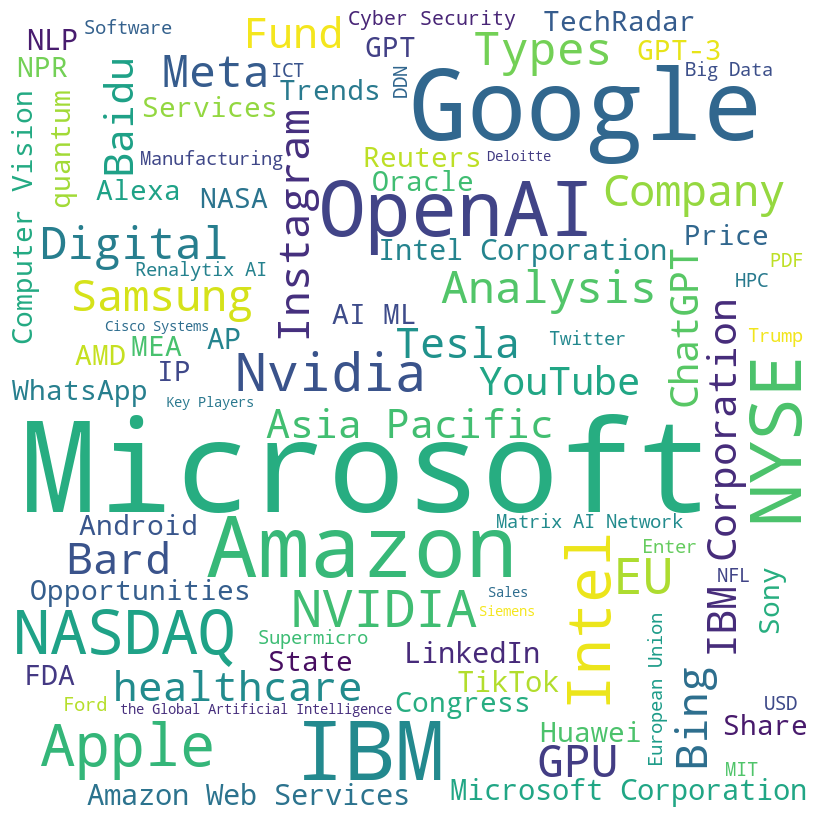

In [51]:
# Convert DataFrame to word-frequency dict
word_freq_dict = df_ORG_positive_100.set_index('Entity')['positive_count'].to_dict()

# Generate word cloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate_from_frequencies(word_freq_dict)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [3]:
df_ORG_negatie_100 = analyze_entity(ner_sentiment_all, 'ORG', 500, 'negative_count', False, 100)
df_ORG_negative_100.head(10)

NameError: name 'ner_sentiment_all' is not defined

In [40]:
df_PERSON_positive_100 = analyze_entity(ner_sentiment_all, 'PERSON', 500, 'positive_count', False, 100)[3:]
df_PERSON_positive_100.head()

,Entity,Label,total_sentiment,count,average_sentiment,positive_count,negative_count
532674,Musk,PERSON,688.0801,7852,0.087631,3639,2643
105450,Biden,PERSON,240.0358,6049,0.039682,2886,2552
607973,Porter,PERSON,1332.6503,3426,0.388981,2628,134
338066,Gross Margin,PERSON,1022.5521,3543,0.288612,2274,1264
153311,Challenges,PERSON,1307.3878,1648,0.793318,1620,27


In [53]:
entities_to_drop = ['Gross Margin', 'Challenges', 'Competitive Landscape', 'Python']

rows_to_drop = df_PERSON_positive_100[df_PERSON_positive_100['Entity'].isin(entities_to_drop)].index

df_PERSON_positive_100 = df_PERSON_positive_100.drop(rows_to_drop)

df_PERSON_positive_100.head(10)

,Entity,Label,total_sentiment,count,average_sentiment,positive_count,negative_count
532674,Musk,PERSON,688.0801,7852,0.087631,3639,2643
105450,Biden,PERSON,240.0358,6049,0.039682,2886,2552
607973,Porter,PERSON,1332.6503,3426,0.388981,2628,134
437639,Kim Kardashian,PERSON,945.9916,1856,0.509694,1418,414
413190,Joe Biden,PERSON,384.6503,2374,0.162026,1393,768
672444,Sam Altman,PERSON,398.7623,2453,0.162561,1240,491
249734,Elon Musk,PERSON,412.2080,2255,0.182797,1236,575
411735,Jim Thorpe,PERSON,178.8389,2205,0.081106,1116,899
229087,Donald Trump,PERSON,-22.5808,2265,-0.009969,1001,1047
494478,Mark Zuckerberg,PERSON,373.2155,1678,0.222417,991,394


In [43]:
df_PERSON_positive_100.shape

(95, 7)

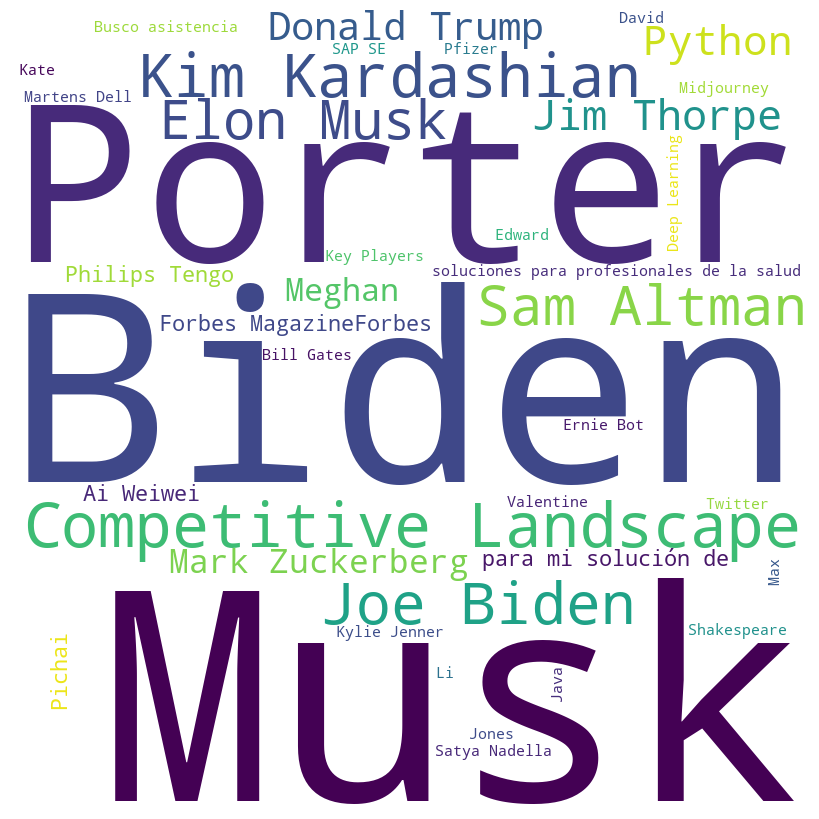

In [44]:
# Convert DataFrame to word-frequency dict
word_freq_dict = df_PERSON_positive_100.set_index('Entity')['positive_count'].to_dict()

# Generate word cloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate_from_frequencies(word_freq_dict)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [74]:
analyze_entity(ner_sentiment_all, 'ORG', 500, 'negative_count', False, 10)

,Entity,Label,total_sentiment,count,average_sentiment,positive_count,negative_count
11754,AI,ORG,77448.6245,232549,0.333042,159773,33641
514817,Microsoft,ORG,17749.7820,58707,0.302345,38485,7988
330435,Google,ORG,8231.8232,35680,0.230713,21260,7213
573975,OpenAI,ORG,5473.4163,20209,0.270841,12740,2967
47543,Amazon,ORG,7896.1054,18653,0.423316,15765,2386
479060,ML,ORG,8037.0736,20343,0.395078,15130,2294
667217,SPAM,ORG,-1072.3275,2146,-0.499687,0,2146
240211,EU,ORG,1990.1596,8044,0.247409,5071,1922
20174,AP,ORG,562.1925,5554,0.101223,2909,1885
784720,Trump,ORG,-167.1937,3943,-0.042403,1731,1742


In [78]:
analyze_entity(ner_sentiment_all, 'ORG', 5000, 'average_sentiment', False, 20)

,Entity,Label,total_sentiment,count,average_sentiment,positive_count,negative_count
282274,Forecast,ORG,8597.9057,10731,0.801221,10125,165
539591,NYSE,ORG,8724.3068,12347,0.706593,11009,402
69118,Artificial Intelligence (AI,ORG,3985.0272,6132,0.649874,5951,166
534594,NASDAQ,ORG,6042.9251,9324,0.648104,8073,505
69023,Artificial Intelligence,ORG,8135.8634,12578,0.646833,12076,473
884164,the Artificial Intelligence (AI,ORG,3942.3772,6784,0.581129,6627,146
884153,the Artificial Intelligence,ORG,2853.6883,5002,0.570509,4878,108
352477,Healthcare,ORG,4671.2415,8239,0.566967,7563,275
395276,IoT,ORG,5477.9786,10762,0.509011,9021,554
369253,IBM,ORG,9020.3528,18092,0.498582,14702,1057


In [77]:
analyze_entity(ner_sentiment_all, 'ORG', 5000, 'average_sentiment', True, 10)

,Entity,Label,total_sentiment,count,average_sentiment,positive_count,negative_count
20174,AP,ORG,562.1925,5554,0.101223,2909,1885
537689,NPR,ORG,660.5909,5491,0.120304,2042,825
107637,Bing,ORG,1201.5727,6962,0.172590,3722,1523
95307,Bard,ORG,1260.7259,7205,0.174979,3646,1570
750195,Tesla,ORG,1328.6949,6152,0.215978,3412,1379
156273,ChatGPT,ORG,1125.2974,5168,0.217743,3002,892
330435,Google,ORG,8231.8232,35680,0.230713,21260,7213
510305,Meta,ORG,1600.2615,6652,0.240568,4110,1260
240211,EU,ORG,1990.1596,8044,0.247409,5071,1922
573975,OpenAI,ORG,5473.4163,20209,0.270841,12740,2967


#### Word Cloud

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

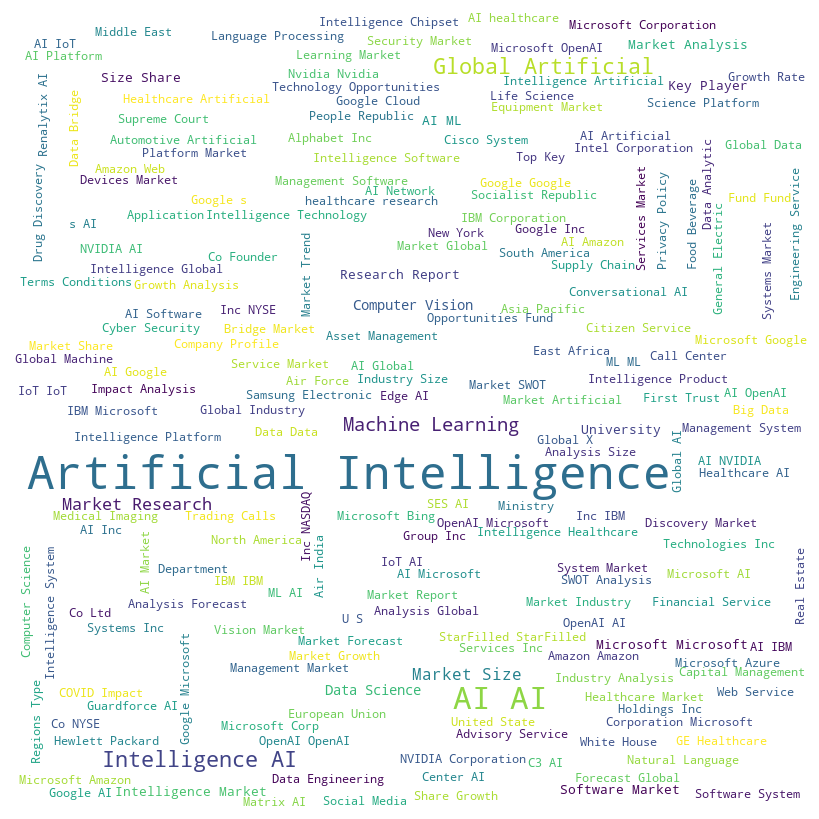

In [16]:
df_org = ner_sentiment_all[(ner_sentiment_all['Label'] == 'ORG') & (ner_sentiment_all['Sentiment'] == 'Positive')]
words_org = ' '.join(df_org['Entity'])

# Generate word cloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(words_org)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

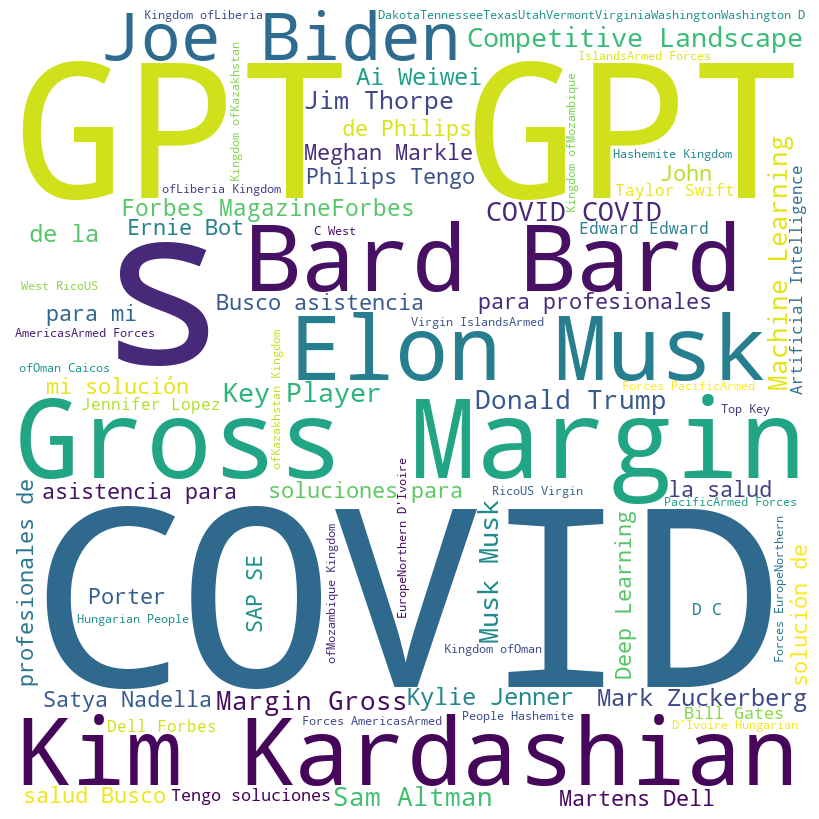

In [17]:
# Filter by positive sentiment and label PERSON
df_person = ner_sentiment_all[(ner_sentiment_all['Label'] == 'PERSON') & (ner_sentiment_all['Sentiment'] == 'Positive')]
words_person = ' '.join(df_person['Entity'])

# Generate word cloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(words_person)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

## NER and Sentiment Analysis with IBM Cloud Natural Language Understanding

In [84]:
%%time
df_filtered = pd.read_pickle('filtered_data_sentiment_NER.pkl')
df_filtered.head(1)

CPU times: total: 13.2 s
Wall time: 44.3 s


,date,domain,clean_title,clean_text,clean_token,sentiment_score_vader,sentiment_vader,sentiment_svm,sentiment_score_vader_customized,sentiment_vader_customized,NER_word,ORG_NER,PERSON_NER,GPE_NER,sentiment_ner
0,2021-03-18,en.people.cn,Artificial intelligence improves parking effic...,Thanks to the application of an artificial int...,thanks application artificial intelligence ai ...,0.997,Positive,0,0.9961,Positive,"[[ETC, ETC, AI, Wang, ETC, Wang, ETC, Ministry...","[ETC, ETC, AI, Wang, ETC, Wang, ETC, Ministry ...","[Xiang Yanping, Xiang]","[China, Beijing, Chaoyang, Beijing, Beijing, B...",E...


In [ ]:
authenticator = IAMAuthenticator('0yS4himg3zyThDmP0gti2YL5g_jjwdj6B3PR9yNfDCwT')
natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2021-03-25',
    authenticator=authenticator
)

natural_language_understanding.set_service_url('https://api.us-east.natural-language-understanding.watson.cloud.ibm.com/instances/0566161f-2164-454b-880b-83bfff9b660a')

#### Sample